# Задача по удалению фона с картинки.

Подключим гугл-диск.

In [ ]:
# Google drive
from google.colab import drive

drive.mount('/content/gdrive/')
root_path = 'gdrive/My Drive/'

Mounted at /content/gdrive/


Проверим возможность использования GPU.

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Датасет будет скачем с кагла, так что загрузим файл json.

In [ ]:
#Loading kaggle API
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nataliamakferson","key":"a2972f9b0896a2d96262a61107b64749"}'}

Скачиваем датасет.

In [ ]:
!pip install kaggle==1.5.6
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json  

#Loading dataset
!kaggle datasets download -d nikhilroxtomar/person-segmentation
!unzip -q /content/person-segmentation.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 4.3 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72858 sha256=968d0f81a5450f8a8157766de4f15920660ce6e301a5a684e3f625cf052a2e7e
  Stored in directory: /root/.cache/pip/wheels/aa/e7/e7/eb3c3d514c33294d77ddd5a856bdd58dc9c1fabbed59a02a2b
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
 96% 441M/461M [00:06<00:00, 57.3MB/s]
100% 461M/461M [00:06<00:00, 72.0MB/s]


Подгружаем нужные библиотеки.

In [ ]:
import torch
import cv2
import numpy as np

from skimage.transform import resize

from pathlib import Path
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import transforms


import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams

Пропишем функцию для получения путей к картинкаим.

In [ ]:
def get_path(file_txt):
    images_path = []
    masks_path = []
    for line in file_txt.readlines():
        images_path.append(Path('/content/people_segmentation/images/' + line.rstrip() + '.jpg'))
        masks_path.append(Path('/content/people_segmentation/masks/' + line.rstrip() + '.png'))
    return sorted(images_path), sorted(masks_path)

Получим пути к картинкам и маскам к ним.

In [ ]:
train_img_mask = open('/content/people_segmentation/segmentation/train.txt')
val_img_mask = open('/content/people_segmentation/segmentation/val.txt')

train_images, train_masks = get_path(train_img_mask)
val_images, val_masks = get_path(val_img_mask)

зададим размер, к котору приведем все картинки.

In [ ]:
SIZE = (256, 256)

Зададим функцию для получения картинок и масок ввиде списка из массивов.

In [ ]:
def get_data(images, masks, image_size = SIZE):

    dataset_size = len(images)
    
    X, y = [], []
    for img, mask in tqdm(zip(images, masks), total=dataset_size):

        # Считываем картинки и маски к ним.
        img = Image.open(img)
        img.load()
        mask = Image.open(mask)
        mask.load()

        # Делаем рпешейп
        img = np.array(img.resize(image_size)) 
        mask = np.array(mask.resize(image_size))
        
        # Нормализация
        img = np.array(img/255, dtype='float32')
        
        # Делаем изображение 3-х канальным при необходимости.
        if (len(img.shape)==3 and img.shape[2]!=3): 
            img = np.stack((img,)*3, axis=-1)
        
        if (len(img.shape)!=3): 
            img = np.stack((img,)*3, axis=-1)

        X.append(img)
        y.append(mask)
    
    return X, y

Теперь получим картинки и маски к ним для тренировочного и тестового набора ввиде массивов.

In [ ]:
X_train, y_train = get_data(train_images, train_masks)
X_val, y_val = get_data(val_images, val_masks)

100%|██████████| 568/568 [00:11<00:00, 51.60it/s]


In [ ]:
X_train, y_train = np.array(X_train, np.float32), np.array(y_train, np.float32)
X_val, y_val = np.array(X_val, np.float32), np.array(y_val, np.float32)


Чтобы убедиться, что все корректно, нарисуем несколько изображений.

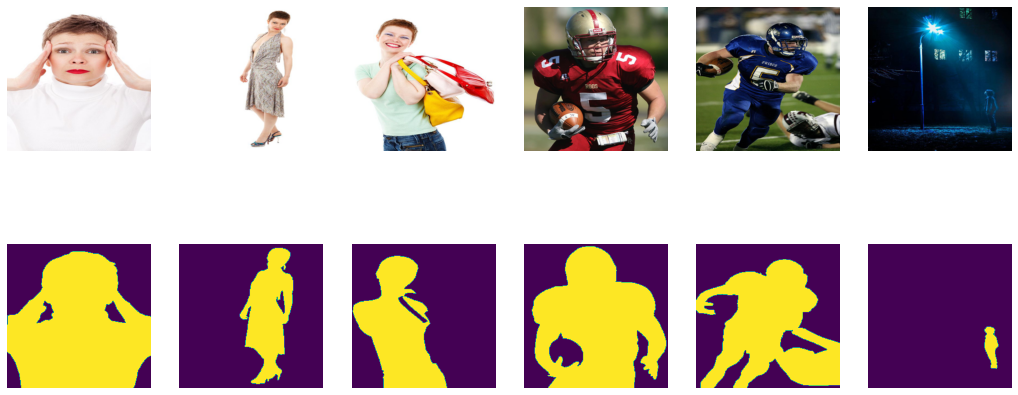

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 8))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X_val[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(y_val[i])
plt.show();

Теперь из массивов картинок получим тензоры, используя PyTorch.

In [ ]:
X_train_t = []
X_val_t = []
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
for x in X_val:
  X_val_t.append(transform(x))
for x in X_train:
  X_train_t.append(transform(x))

Созданим даталоудеры.

In [ ]:
BATCH_SIZE = 16
dataloaders = {'train': DataLoader(list(zip(X_train_t, y_train[:, np.newaxis])), batch_size=BATCH_SIZE, shuffle=True),
               'val': DataLoader(list(zip(X_val_t, y_val[:, np.newaxis])), batch_size=BATCH_SIZE, shuffle=False)}
dataset_sizes = {'train': len(y_train), 'val':len(y_val)}

 **Метрика**
 
Будем использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):

    outputs = outputs.squeeze(1).byte()   # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))   # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))  # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded

**Функция потерь**



In [ ]:
def bce_loss(y_real, y_pred):
    return (y_pred - (y_real * y_pred) + torch.log(1 + torch.exp(-y_pred))).sum()

Определим функцию обучения.

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):

    best_model = model.state_dict()
    best_score = 0.0
    losses = {'train': [], "val": []}   #Здесь будем сохранять значения функции потерь для каждой эпохи.
    for epoch in tqdm(range(epochs)):
        loss_epoch = 0
        epoch_pred = []
        epoch_true = []

        #TRAIN MODE
        model.train() 
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred)
            loss.backward()
            opt.step()
            loss_epoch += loss.cpu().detach().numpy()
        losses['train'].append(loss_epoch/dataset_sizes['train'])

        # TEST MODE        
        loss_epoch = 0
        model.eval()  
        for X_batch, Y_batch in data_val:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # set parameter no zero gradients 
            with torch.no_grad():
                Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred)
            loss_epoch += loss.cpu().detach().numpy()
            for y_pred, y_true in zip(Y_pred.cpu().data.numpy(), Y_batch.cpu().data.numpy()):
                epoch_pred.append(y_pred)
                epoch_true.append(y_true)
        epoch_score = iou_pytorch((torch.tensor(epoch_pred)>0.5).to(device), torch.tensor(epoch_true).to(device)).mean().item()
        print(epoch_score)
        if epoch_score > best_score:
            best_score = epoch_score
            best_model = model.state_dict()
        losses['val'].append(loss_epoch/dataset_sizes['val'])
    return losses, best_model

Определим функцию для прогнозирования сегментации на новых данных, после обучения модели.

In [ ]:
def predict(model, X):
    with torch.no_grad():
        model.eval()  # testing mode
        y_pred = model(X.to(device))
    return y_pred.cpu().detach().numpy()

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model(X_batch.to(device))
        scores += metric(Y_pred>0.5, Y_label.to(device)).mean().item()

        del Y_pred, Y_label, X_batch
        torch.cuda.memory.empty_cache()
    return scores/len(data)

Реализация архитектуры UNet.

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
                  nn.Conv2d(3, 64, kernel_size=3, padding=1),
                  nn.BatchNorm2d(64),
                  nn.ReLU(inplace=True),
                  nn.Conv2d(64, 64, kernel_size=3, padding=1),
                  nn.BatchNorm2d(64),
                  nn.ReLU(inplace=True))
        self.pool0 = nn.MaxPool2d(2)
        self.enc_conv1 = nn.Sequential(
                  nn.Conv2d(64, 128, kernel_size=3, padding=1),
                  nn.BatchNorm2d(128),
                  nn.ReLU(inplace=True),
                  nn.Conv2d(128, 128, kernel_size=3, padding=1),
                  nn.BatchNorm2d(128),
                  nn.ReLU(inplace=True))
        self.pool1 = nn.MaxPool2d(2)
        self.enc_conv2 = nn.Sequential(
                  nn.Conv2d(128, 256, kernel_size=3, padding=1),
                  nn.BatchNorm2d(256),
                  nn.ReLU(),
                  nn.Conv2d(256, 256, kernel_size=3, padding=1),
                  nn.BatchNorm2d(256),
                  nn.ReLU())
        self.pool2 = nn.MaxPool2d(2)
        self.enc_conv3 = nn.Sequential(
                  nn.Conv2d(256, 512, kernel_size=3, padding=1),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 512, kernel_size=3, padding=1),
                  nn.BatchNorm2d(512),
                  nn.ReLU())
        self.pool3 = nn.MaxPool2d(2)

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
                  nn.Conv2d(512, 1024, kernel_size=3, padding=1),
                  nn.BatchNorm2d(1024),
                  nn.ReLU(),
                  nn.Conv2d(1024, 512, kernel_size=3, padding=1),
                  nn.BatchNorm2d(512),
                  nn.ReLU())


        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2)
        self.dec_conv0 = nn.Sequential(
                  nn.Conv2d(1024, 512, kernel_size=3, padding=1),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 256, kernel_size=3, padding=1),
                  nn.BatchNorm2d(256),
                  nn.ReLU())
        self.upsample1 = nn.Upsample(scale_factor=2)
        self.dec_conv1 = nn.Sequential(
                  nn.Conv2d(512, 256, kernel_size=3, padding=1),
                  nn.BatchNorm2d(256),
                  nn.ReLU(),
                  nn.Conv2d(256, 128, kernel_size=3, padding=1),
                  nn.BatchNorm2d(128),
                  nn.ReLU())
        self.upsample2 = nn.Upsample(scale_factor=2)
        self.dec_conv2 = nn.Sequential(
                  nn.Conv2d(256, 128, kernel_size=3, padding=1),
                  nn.BatchNorm2d(128),
                  nn.ReLU(),
                  nn.Conv2d(128, 64, kernel_size=3, padding=1),
                  nn.BatchNorm2d(64),
                  nn.ReLU())
        self.upsample3 = nn.Upsample(scale_factor=2)
        self.dec_conv3 = nn.Sequential(
                  nn.Conv2d(128, 64, kernel_size=3, padding=1),
                  nn.BatchNorm2d(64),
                  nn.ReLU(),
                  nn.Conv2d(64, 64, kernel_size=3, padding=1),
                  nn.BatchNorm2d(64),
                  nn.ReLU(),
                  nn.Conv2d(64, 1, kernel_size=1))

    def forward(self, x):

        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))

        # bottleneck
        b = self.pool3(self.bottleneck_conv(e3))

        #decoder
        d0 = self.dec_conv0(torch.cat([e3, self.upsample0(b)], dim=1))
        d1 = self.dec_conv1(torch.cat([e2, self.upsample1(d0)], dim=1))
        d2 = self.dec_conv2(torch.cat([e1, self.upsample2(d1)], dim=1))
        d3 = self.dec_conv3(torch.cat([e0, self.upsample3(d2)], dim=1))
        return d3

In [ ]:
model = UNet().to(device)

In [ ]:
max_epochs = 25
optimize = torch.optim.Adam(model.parameters())
losses, best_model = train(model, optimize, bce_loss, max_epochs, dataloaders['train'], dataloaders['val'])

  4%|▍         | 1/25 [04:14<1:41:51, 254.66s/it]

0.09929577261209488


  8%|▊         | 2/25 [08:28<1:37:31, 254.40s/it]

0.21514084935188293


 12%|█▏        | 3/25 [12:43<1:33:23, 254.70s/it]

0.10792253166437149


 16%|█▌        | 4/25 [16:59<1:29:15, 255.02s/it]

0.2195422500371933


 20%|██        | 5/25 [21:15<1:25:08, 255.45s/it]

0.2908450961112976


 24%|██▍       | 6/25 [25:32<1:21:00, 255.84s/it]

0.27077463269233704


 28%|██▊       | 7/25 [29:48<1:16:47, 255.99s/it]

0.19489435851573944


 32%|███▏      | 8/25 [34:04<1:12:34, 256.12s/it]

0.44718310236930847


 36%|███▌      | 9/25 [38:21<1:08:21, 256.36s/it]

0.4172535538673401


 40%|████      | 10/25 [42:38<1:04:05, 256.39s/it]

0.4373239576816559


 44%|████▍     | 11/25 [46:54<59:48, 256.34s/it]  

0.4843309819698334


 48%|████▊     | 12/25 [51:11<55:33, 256.43s/it]

0.4235915541648865


 52%|█████▏    | 13/25 [55:28<51:20, 256.67s/it]

0.45528170466423035


 56%|█████▌    | 14/25 [59:44<47:02, 256.61s/it]

0.5600352883338928


 60%|██████    | 15/25 [1:04:01<42:46, 256.61s/it]

0.4795774519443512


 64%|██████▍   | 16/25 [1:08:18<38:29, 256.66s/it]

0.5549296140670776


 68%|██████▊   | 17/25 [1:12:34<34:12, 256.62s/it]

0.5605633854866028


 72%|███████▏  | 18/25 [1:16:51<29:55, 256.54s/it]

0.5917253494262695


 76%|███████▌  | 19/25 [1:21:08<25:39, 256.64s/it]

0.5531690120697021


 80%|████████  | 20/25 [1:25:24<21:23, 256.72s/it]

0.5964788794517517


 84%|████████▍ | 21/25 [1:29:41<17:06, 256.62s/it]

0.5660211443901062


 88%|████████▊ | 22/25 [1:33:58<12:50, 256.70s/it]

0.5649648308753967


 92%|█████████▏| 23/25 [1:38:14<08:33, 256.68s/it]

0.612852156162262


 96%|█████████▌| 24/25 [1:42:32<04:16, 256.84s/it]

0.5850352048873901


100%|██████████| 25/25 [1:46:48<00:00, 256.35s/it]

0.5834507346153259


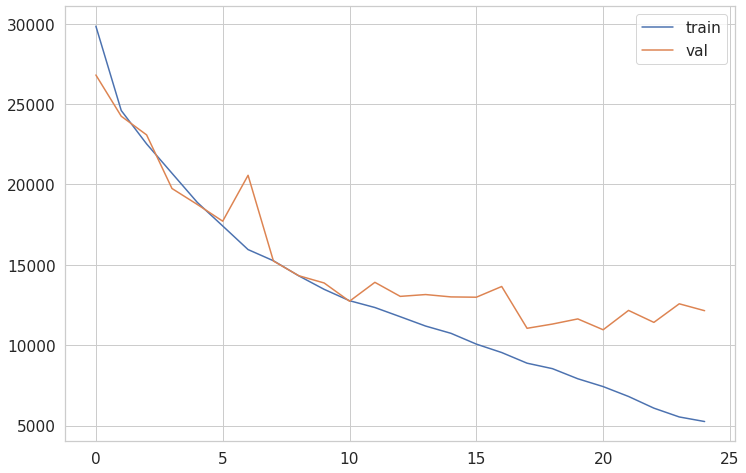

In [ ]:
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.4)
plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.legend()
plt.show()

In [ ]:
score_model(model, iou_pytorch, dataloaders['val'])

0.5812500152322981

In [ ]:
#torch.save(model.state_dict(), 'my_SegNet_20.pth')

Модель обучена, веса загружены.

Теперь удалим фон с новых картинок.

In [ ]:
TEST_DIR = Path('/content/gdrive/MyDrive/test_images/image')

test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
def remove_background(images, image_size = SIZE):
    dataset_size = len(images)
    photos = []
    transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
    for img in tqdm(images, total=dataset_size):
        rgb = True
        # Считываем картинки.
        img = Image.open(img)
        img.load()
        # Запонимаем первоначальный размер
        H, W = img.size
        # Делаем рпешейп
        X = np.array(img.resize(image_size))        
        # Нормализация
        X = np.array(X / 255, dtype='float32')

        # Делаем изображение 3-х канальным при необходимости.
        if (len(X.shape)==3 and X.shape[2]!=3): 
            rgb = False
            X = np.stack((X, X, X))
            X = np.rollaxis(X, 0, 3)
        
        if (len(X.shape)!=3): 
            rgb = False
            X = np.stack((X, X, X))
            X = np.rollaxis(X, 0, 3)
        X = transform(X)

        X = np.expand_dims(X, axis=0)

        
        #X = np.rollaxis(X, 3, 1)
        X = torch.Tensor(X)
        #Prediction
        y = predict(model, X)[0]
        y = np.rollaxis(y, 0, 3)

        y = cv2.resize(y, (H, W))
        if rgb == True:
            y = np.expand_dims(y, axis=-1) 
        y = y > 0.5       
        masked_photo = img * y 
        #cv2.imwrite(f"remove_bg/{name}.png", final_photo)
        photos.append(masked_photo)  
    return photos

In [ ]:
photos = remove_background(test_files)

100%|██████████| 17/17 [00:02<00:00,  8.15it/s]


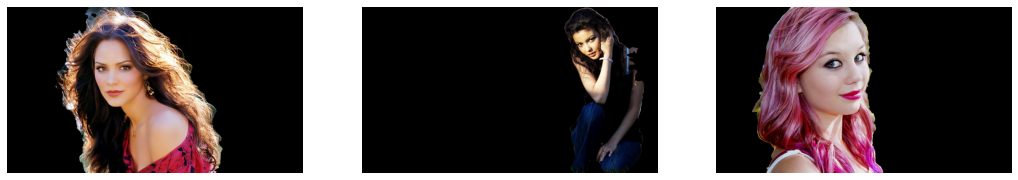

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
plt.figure(figsize=(18, 8))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.axis("off")
    plt.imshow(photos[i])

plt.show();